# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Шаг 1. Откройте файлы с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier 

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/datasets/hotel_train_old.csv')
test = pd.read_csv('/datasets/hotel_test_old.csv')

In [3]:
pd.set_option('display.max_columns', None)

### Шаг 2. Предобработка и исследовательский анализ данных

In [4]:
for data in [train, test]: print(data.info(), end='\n\n'), display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32417 entries, 0 to 32416
Data columns (total 29 columns):
is_canceled                       32417 non-null int64
lead_time                         30948 non-null float64
arrival_date_year                 32417 non-null int64
arrival_date_month                32417 non-null object
arrival_date_week_number          32417 non-null int64
arrival_date_day_of_month         32417 non-null int64
stays_in_weekend_nights           32417 non-null int64
stays_in_week_nights              32417 non-null int64
adults                            31001 non-null float64
children                          30929 non-null float64
babies                            30920 non-null float64
meal                              30975 non-null object
country                           32417 non-null object
distribution_channel              30973 non-null object
is_repeated_guest                 32417 non-null int64
previous_cancellations            32417 non-null int64

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_nights,price
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,C,0,999,999,0,Transient,75.00,0,0,1,75.00
1,0,13.0,2015,July,27,1,0,1,1.0,0.0,NaN,BB,GBR,Corporate,0,0,0,A,A,0,304,999,0,Transient,75.00,0,0,1,75.00
2,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,A,0,240,999,0,Transient,98.00,0,1,2,196.00
3,0,NaN,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,A,0,240,999,0,Transient,98.00,0,1,2,196.00
4,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,C,0,999,999,0,Transient,107.00,0,0,2,214.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32412,0,21.0,2017,August,35,31,2,5,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,E,E,0,40,999,0,Contract,101.70,0,2,7,711.90
32413,0,279.0,2017,August,35,31,2,5,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,A,0,40,999,0,Contract,72.20,0,1,7,505.40
32414,0,191.0,2017,August,35,31,2,5,2.0,0.0,0.0,HB,GBR,TA/TO,0,0,0,D,D,0,40,999,0,Contract,114.80,0,0,7,803.60
32415,0,227.0,2017,August,35,31,2,5,2.0,1.0,0.0,BB,CN,TA/TO,0,0,0,A,A,0,241,999,0,Transient,127.58,0,1,7,893.06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73270 entries, 0 to 73269
Data columns (total 29 columns):
is_canceled                       73270 non-null int64
lead_time                         73270 non-null int64
arrival_date_year                 73270 non-null int64
arrival_date_month                73270 non-null object
arrival_date_week_number          73270 non-null int64
arrival_date_day_of_month         73270 non-null int64
stays_in_weekend_nights           73270 non-null int64
stays_in_week_nights              73270 non-null int64
adults                            73270 non-null int64
children                          73270 non-null float64
babies                            73270 non-null int64
meal                              73270 non-null object
country                           73270 non-null object
distribution_channel              73270 non-null object
is_repeated_guest                 73270 non-null int64
previous_cancellations            73270 non-null int64
previ

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_nights,price
0,1,88,2015,July,27,1,0,4,2,0.0,0,BB,PRT,TA/TO,0,0,0,A,A,0,9,999,0,Transient,76.50,0,1,4,306.00
1,1,65,2015,July,27,1,0,4,1,0.0,0,BB,PRT,TA/TO,0,0,0,A,A,0,9,999,0,Transient,68.00,0,1,4,272.00
2,1,92,2015,July,27,1,2,4,2,0.0,0,BB,PRT,TA/TO,0,0,0,A,A,0,9,999,0,Transient,76.50,0,2,6,459.00
3,1,100,2015,July,27,2,0,2,2,0.0,0,BB,PRT,TA/TO,0,0,0,A,A,0,9,999,0,Transient,76.50,0,1,2,153.00
4,1,79,2015,July,27,2,0,3,2,0.0,0,BB,PRT,TA/TO,0,0,0,A,A,0,9,999,0,Transient,76.50,0,1,3,229.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73265,0,164,2017,August,35,31,2,4,2,0.0,0,BB,DEU,TA/TO,0,0,0,A,A,0,42,999,0,Transient,87.60,0,0,6,525.60
73266,0,21,2017,August,35,30,2,5,2,0.0,0,BB,BEL,TA/TO,0,0,0,A,A,0,394,999,0,Transient,96.14,0,2,7,672.98
73267,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,TA/TO,0,0,0,A,A,0,394,999,0,Transient,96.14,0,0,7,672.98
73268,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,TA/TO,0,0,0,D,D,0,9,999,0,Transient,157.71,0,4,7,1103.97


В тестовом наборе данных содержатся пропуски. Некоторые столбцы требуют замены типов.

In [5]:
# удаляю ненужные столбцы: adr неинформативен, price по словам преподавателя по проекту остался в данных случайно

train = train.drop(['adr','price'], axis=1)
test = test.drop(['adr','price'], axis=1)

Можно предположить, что пропуски в столбцах `children` и `babies` означают, что гость заселяется без детей. 

Пропуски в столбце `lead_time` вероятно говорят о том, что между бронированием и заселением прошло меньше суток. Кроме того, в описании нет прямого указания на то, что в датасете содержатся исключительно данные о бронированиях, поэтому можно допустить, что пропуски в столбце `lead_time` указывают на заселение без предварительной брони, т.е. и в этом случае можно заполнить нулями.

In [6]:
# замена типов данных

columns = ['adults', 'children', 'babies']
train[columns] = train[columns].astype('Int64')
test[columns] = test[columns].astype('Int64')

Пропуски в столбце adults заменяю средним значением.

In [7]:
train['adults'] = train['adults'].fillna(train['adults'].mean().astype(np.int64))

In [8]:
# заполнение пропусков

columns_0 = ['lead_time', 'children', 'babies']

train[columns_0] = train[columns_0].fillna(0)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32417 entries, 0 to 32416
Data columns (total 27 columns):
is_canceled                       32417 non-null int64
lead_time                         32417 non-null float64
arrival_date_year                 32417 non-null int64
arrival_date_month                32417 non-null object
arrival_date_week_number          32417 non-null int64
arrival_date_day_of_month         32417 non-null int64
stays_in_weekend_nights           32417 non-null int64
stays_in_week_nights              32417 non-null int64
adults                            32417 non-null Int64
children                          32417 non-null Int64
babies                            32417 non-null Int64
meal                              30975 non-null object
country                           32417 non-null object
distribution_channel              30973 non-null object
is_repeated_guest                 32417 non-null int64
previous_cancellations            32417 non-null int64
previ

Перейдем к категориальным пропускам: пропущенные значения в столбце `канал дистрибуции заказа` воccтановить не удастся, для удобства заменим пропуски на пустую строку. Пропуски в столбце `meal` заменим на значение SC - заказ без дополнительных опций.

In [10]:
train['distribution_channel'] = train['distribution_channel'].fillna(value='')
train['meal'] = train['meal'].fillna(value='SC')

In [11]:
for data in [train, test]: print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32417 entries, 0 to 32416
Data columns (total 27 columns):
is_canceled                       32417 non-null int64
lead_time                         32417 non-null float64
arrival_date_year                 32417 non-null int64
arrival_date_month                32417 non-null object
arrival_date_week_number          32417 non-null int64
arrival_date_day_of_month         32417 non-null int64
stays_in_weekend_nights           32417 non-null int64
stays_in_week_nights              32417 non-null int64
adults                            32417 non-null Int64
children                          32417 non-null Int64
babies                            32417 non-null Int64
meal                              32417 non-null object
country                           32417 non-null object
distribution_channel              32417 non-null object
is_repeated_guest                 32417 non-null int64
previous_cancellations            32417 non-null int64
previ

In [12]:
print(train['assigned_room_type'].value_counts())
print(test['assigned_room_type'].value_counts())

A                   14611
D                    8493
E                    4351
C                    1715
F                    1349
G                    1206
H                     428
B                     141
I                     122
L                       1
Name: assigned_room_type, dtype: int64
A                   53362
D                   14274
B                    1867
E                    1843
F                    1348
G                     301
C                     141
K                     134
Name: assigned_room_type, dtype: int64


Типы номеров в обеих выборках содержат лишние и неверные значения.

In [13]:
test['assigned_room_type'] = test['assigned_room_type'].str.strip()
train['assigned_room_type'] = train['assigned_room_type'].str.strip()

train = train[train['assigned_room_type'] != 'I']
train = train[train['assigned_room_type'] != 'L']

test['assigned_room_type'] = test['assigned_room_type'].replace('K', 'H')

print(train['assigned_room_type'].value_counts())
print(test['assigned_room_type'].value_counts())

A    14611
D     8493
E     4351
C     1715
F     1349
G     1206
H      428
B      141
Name: assigned_room_type, dtype: int64
A    53362
D    14274
B     1867
E     1843
F     1348
G      301
C      141
H      134
Name: assigned_room_type, dtype: int64


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32294 entries, 0 to 32416
Data columns (total 27 columns):
is_canceled                       32294 non-null int64
lead_time                         32294 non-null float64
arrival_date_year                 32294 non-null int64
arrival_date_month                32294 non-null object
arrival_date_week_number          32294 non-null int64
arrival_date_day_of_month         32294 non-null int64
stays_in_weekend_nights           32294 non-null int64
stays_in_week_nights              32294 non-null int64
adults                            32294 non-null Int64
children                          32294 non-null Int64
babies                            32294 non-null Int64
meal                              32294 non-null object
country                           32294 non-null object
distribution_channel              32294 non-null object
is_repeated_guest                 32294 non-null int64
previous_cancellations            32294 non-null int64
previ

Данные подготовлены. В таблице нет уникального идентификатора клиента, поэтому на наличие дубликатов данные проверять бессмысленно.

In [15]:
print(train.duplicated().sum(), test.duplicated().sum())

4848 24002


Переходим к визуализации:

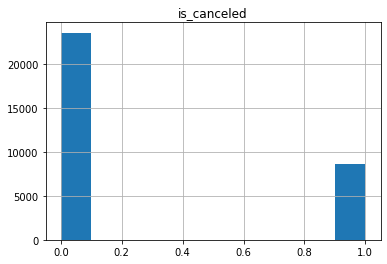

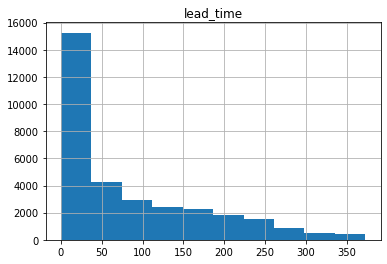

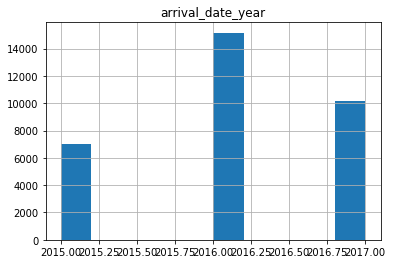

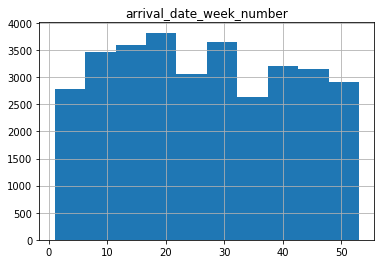

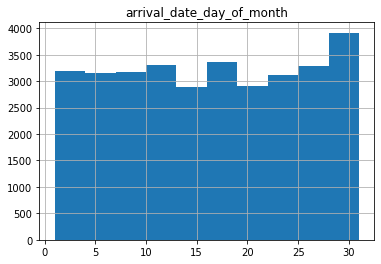

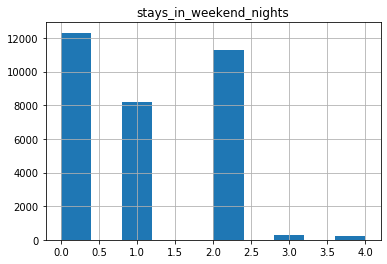

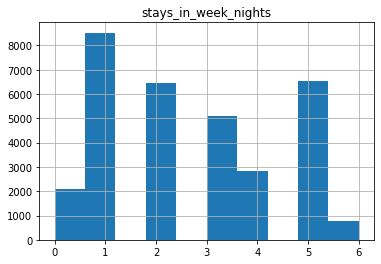

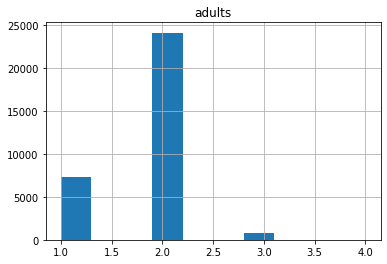

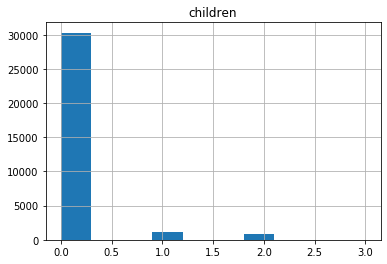

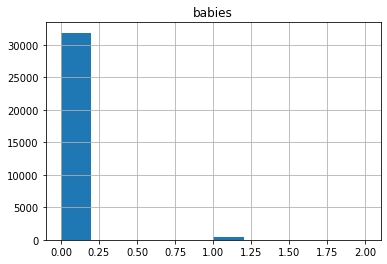

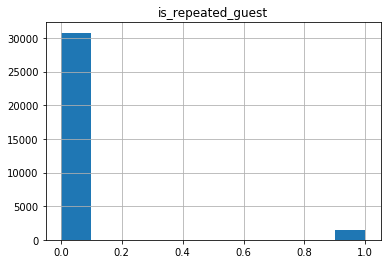

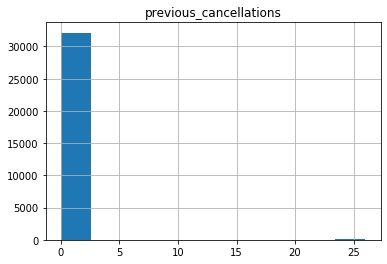

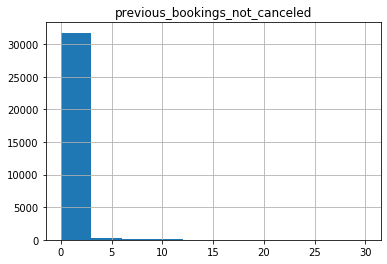

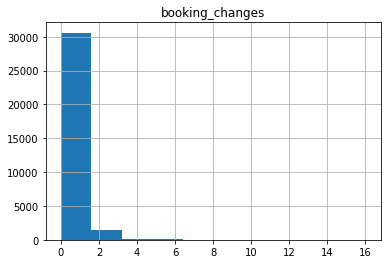

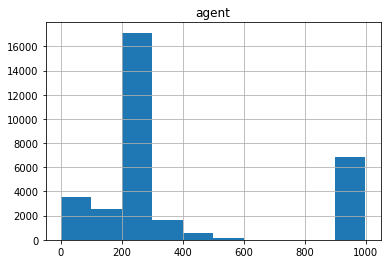

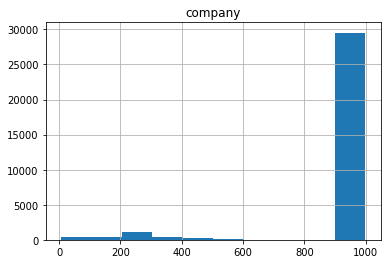

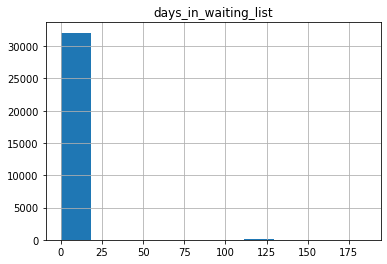

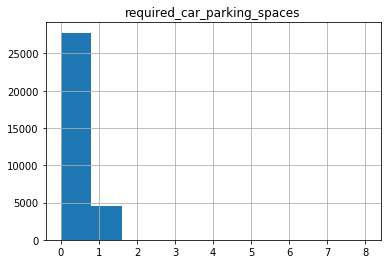

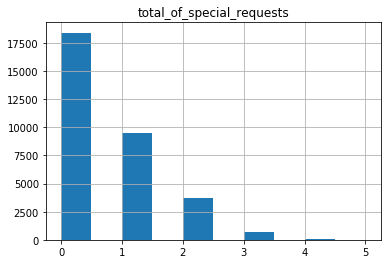

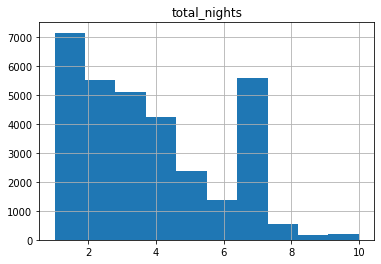

In [16]:
for col in train.columns: 
    try:      
        train[col] = pd.to_numeric(train[col]) 
        train.hist(column=col)
    except ValueError:
        pass

In [17]:
train['agent'].value_counts()

240    11021
999     6840
250     2145
241     1473
314      784
       ...  
406        1
180        1
167        1
34         1
301        1
Name: agent, Length: 177, dtype: int64

In [18]:
train['company'].value_counts()

999    29529
223      765
154      116
405       98
281       81
       ...  
435        1
499        1
377        1
531        1
104        1
Name: company, Length: 222, dtype: int64

In [19]:
train['total_nights'].value_counts()

1     7152
7     5585
2     5528
3     5120
4     4232
5     2378
6     1376
8      562
10     186
9      175
Name: total_nights, dtype: int64

Есть пики на значении 999 в параметрах `agent` и `company`. Скорее всего это какой-то особый код, возможно указывающий на самостоятельное бронирование физическим лицом, без посредников в виде агентов и компаний.

Пик на значении 7 в параметре `total_nights` можно обьяснить скидками на недельное проживание.

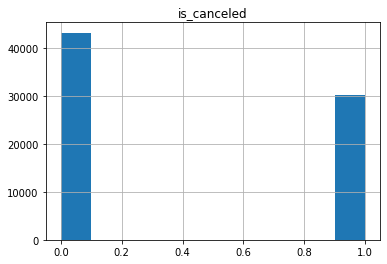

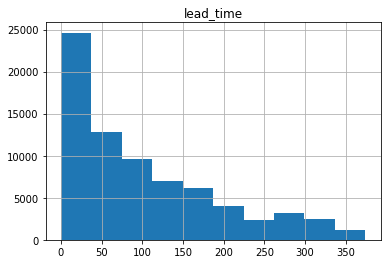

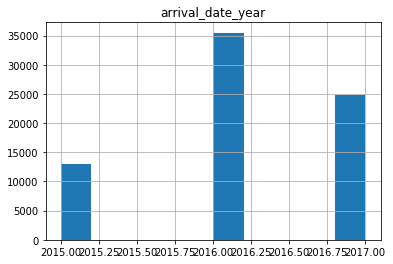

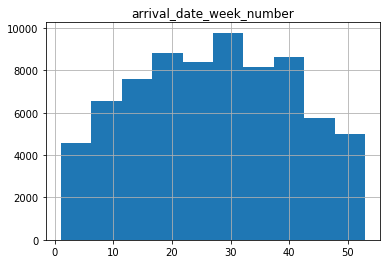

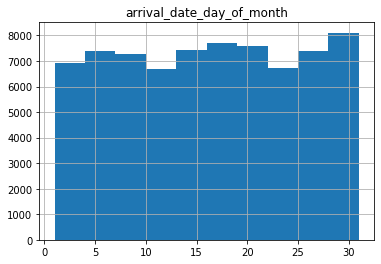

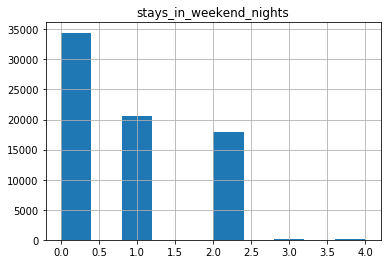

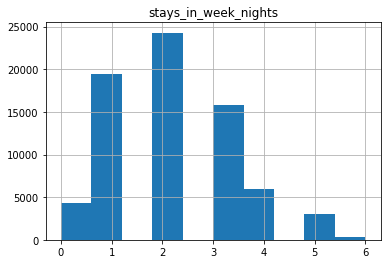

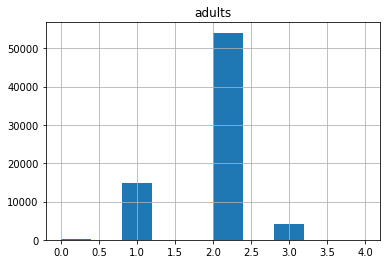

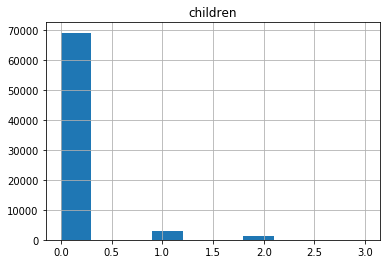

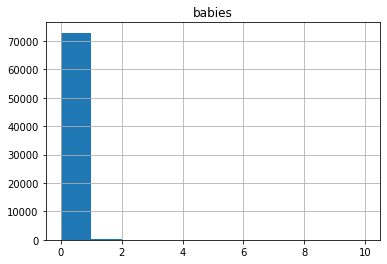

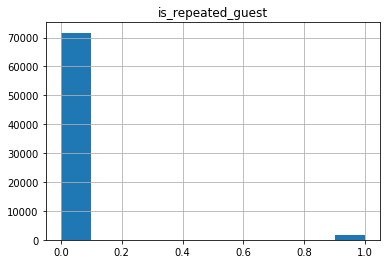

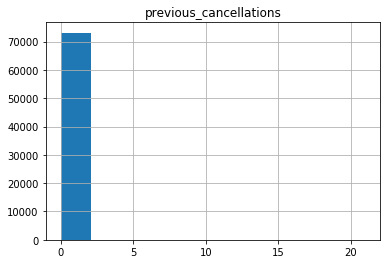

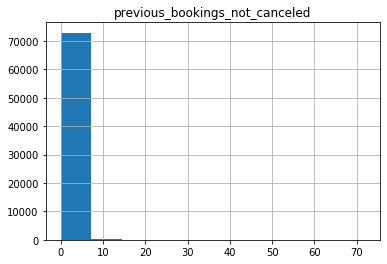

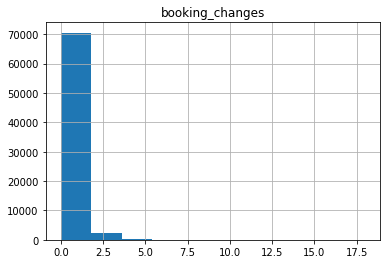

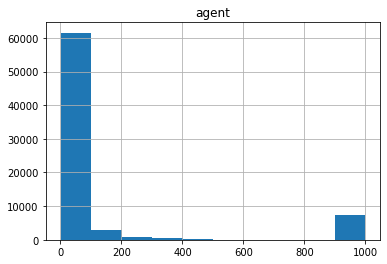

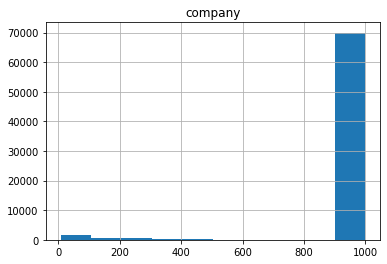

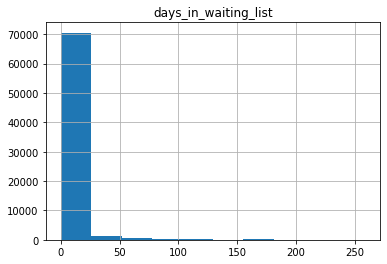

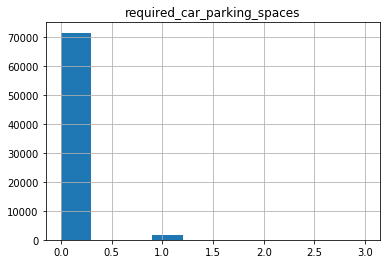

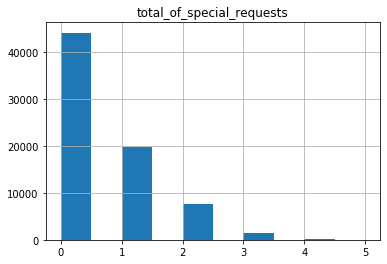

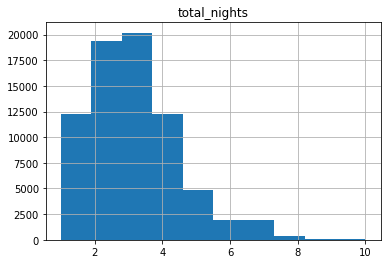

In [20]:
for col in test.columns: 
    try:      
        test[col] = pd.to_numeric(test[col]) 
        test.hist(column=col)
    except ValueError:
        pass

В тестовой выборке все аналогично. Проверим категориальные признаки:

In [21]:
train['arrival_date_month'].value_counts()

April        3370
October      3089
May          3082
July         3001
March        2995
February     2879
September    2579
June         2464
August       2324
December     2322
November     2191
January      1998
Name: arrival_date_month, dtype: int64

In [22]:
test['arrival_date_month'].value_counts()

August       8023
May          7622
June         7384
April        7129
July         7093
October      6980
September    6818
March        6136
February     4722
November     4101
December     3753
January      3509
Name: arrival_date_month, dtype: int64

In [23]:
train['meal'].value_counts()

BB           23948
HB            5383
SC            2387
FB             574
SC               2
Name: meal, dtype: int64

In [24]:
train['meal'] = train['meal'].str.strip()
train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [25]:
test['meal'].value_counts()

BB           57489
SC           10299
HB            5446
FB              36
Name: meal, dtype: int64

In [26]:
train['country'].unique()

array(['GBR', 'PRT', 'USA', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'ARG',
       'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'RUS', 'SWE',
       'AUS', 'EST', 'CZE', 'BRA', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA',
       'LUX', 'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'PRI',
       'SRB', 'IND', 'CHL', 'AUT', 'LTU', 'OMN', 'TUR', 'ZAF', 'ISR',
       'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA', 'KOR', 'CRI', 'HUN', 'ARE',
       'TUN', 'JAM', 'HRV', 'HKG', 'IRN', 'GIB', 'JEY', 'CAF', 'CYP',
       'URY', 'COL', 'GGY', 'BLR', 'KWT', 'NGA', 'MDV', 'VEN', 'AGO',
       'FJI', 'SVK', 'LBN', 'PHL', 'SYC', 'BHR', 'NZL', 'KAZ', 'THA',
       'DOM', 'MKD', 'MYS', 'UKR', 'ARM', 'JPN', 'LKA', 'CUB', 'CMR',
       'BIH', 'MUS', 'COM', 'SUR', 'UGA', 'BGR', 'CIV', 'JOR', 'SYR',
       'SGP', 'BDI', 'SAU', 'VNM', 'AZE', 'PLW', 'EGY', 'MLT', 'MWI',
       'ECU', 'MDG', 'IDN', 'ISL', 'UZB', 'NPL', 'BHS', 'PAK', 'MAC',
       'TWN'], dtype=object)

In [27]:
test['country'].unique()

array(['PRT', 'ITA', 'ESP', 'DEU', 'FRA', 'NLD', 'ROU', 'BRA', 'SWE',
       'GBR', 'AUT', 'BEL', 'CHE', 'NOR', 'RUS', 'ISR', 'IRL', 'POL',
       'CHN', 'USA', 'AGO', 'MAR', 'AUS', 'MOZ', 'TUN', 'DNK', 'MEX',
       'GRC', 'DZA', 'COL', 'LUX', 'CN', 'LVA', 'FIN', 'HRV', 'STP',
       'BGR', 'UKR', 'VEN', 'TWN', 'IRN', 'KOR', 'TUR', 'BLR', 'JPN',
       'CZE', 'HUN', 'AZE', 'KAZ', 'IND', 'NZL', 'IDN', 'LTU', 'LBN',
       'SRB', 'SVN', 'SVK', 'MYS', 'CMR', 'CHL', 'ARG', 'SGP', 'SEN',
       'PER', 'EGY', 'SAU', 'KNA', 'JOR', 'ZAF', 'THA', 'KWT', 'LKA',
       'ALB', 'ETH', 'PHL', 'ARE', 'ECU', 'OMN', 'IRQ', 'AND', 'CPV',
       'MUS', 'HND', 'NGA', 'EST', 'PAK', 'GEO', 'GIB', 'ZMB', 'QAT',
       'KHM', 'HKG', 'MCO', 'BGD', 'ISL', 'UZB', 'URY', 'IMN', 'TJK',
       'ARM', 'MDV', 'NIC', 'GGY', 'BEN', 'MAC', 'CYP', 'VGB', 'MLT',
       'CRI', 'TZA', 'JEY', 'GAB', 'MKD', 'BIH', 'VNM', 'TMP', 'GLP',
       'KEN', 'PRI', 'DOM', 'LIE', 'GNB', 'BHR', 'MNE', 'UMI', 'MYT',
       'CIV', 'ZWE', 

In [28]:
train['distribution_channel'].value_counts()

TA/TO        22213
Direct        5939
Corporate     2706
              1436
Name: distribution_channel, dtype: int64

In [29]:
test['distribution_channel'].value_counts()

TA/TO        63986
Direct        5834
Corporate     3266
GDS            184
Name: distribution_channel, dtype: int64

В тестовой выборке появляется новое значение - GDS.

In [30]:
train['reserved_room_type'].value_counts()

A                   20145
D                    5753
E                    3729
G                     986
F                     791
C                     552
H                     330
L                       5
B                       3
Name: reserved_room_type, dtype: int64

In [31]:
train['reserved_room_type'] = train['reserved_room_type'].str.strip()

train = train[train['reserved_room_type'] != 'L']
train['reserved_room_type'].value_counts()

A    20145
D     5753
E     3729
G      986
F      791
C      552
H      330
B        3
Name: reserved_room_type, dtype: int64

In [32]:
test['reserved_room_type'].value_counts()

A                   58573
D                   11146
E                    1234
F                    1137
B                    1050
G                     120
C                      10
Name: reserved_room_type, dtype: int64

В тестовой выборке нет номеров типа H.

In [33]:
train['customer_type'].value_counts()

Transient          24178
Transient-Party     6750
Contract            1131
Group                230
Name: customer_type, dtype: int64

In [34]:
test['customer_type'].value_counts()

Transient          54750
Transient-Party    16008
Contract            2234
Group                278
Name: customer_type, dtype: int64

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32289 entries, 0 to 32416
Data columns (total 27 columns):
is_canceled                       32289 non-null int64
lead_time                         32289 non-null float64
arrival_date_year                 32289 non-null int64
arrival_date_month                32289 non-null object
arrival_date_week_number          32289 non-null int64
arrival_date_day_of_month         32289 non-null int64
stays_in_weekend_nights           32289 non-null int64
stays_in_week_nights              32289 non-null int64
adults                            32289 non-null Int64
children                          32289 non-null Int64
babies                            32289 non-null Int64
meal                              32289 non-null object
country                           32289 non-null object
distribution_channel              32289 non-null object
is_repeated_guest                 32289 non-null int64
previous_cancellations            32289 non-null int64
previ

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Прибыль отеля — это разница между стоимостью номера за все ночи и затратами на разовое обслуживание.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:

* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 250;
* категория C: за ночь — 600, разовое обслуживание — 250;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 400, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150;
* категория H: за ночь — 300, разовое обслуживание — 100.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

In [36]:
# Словарь с информацией о стоимости номеров в зависимости от категории и расходах на уборку

dict_prices = pd.DataFrame({'assigned_room_type': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],

                            'price': [1000, 800, 600, 550, 500, 400, 350, 300],
  
                            'room_service': [400, 250, 250, 150, 150, 150, 150, 100]})

In [37]:
# Словарь с информацией о сезонных коэффициентах

dict_coefficients = pd.DataFrame({'arrival_date_month': ['January', 'February', 'March', 'April', 'May', 'June',

                                            'July', 'August', 'September','October', 'November', 'December'],

                                  'coefficient': [1.0, 1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1.0]})

In [38]:
# Добавление словарей 

train = train.merge(dict_prices, how='left', on='assigned_room_type')

test = test.merge(dict_prices, how='left', on='assigned_room_type')

train = train.merge(dict_coefficients, how='left', on='arrival_date_month')

test = test.merge(dict_coefficients, how='left', on='arrival_date_month')

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32289 entries, 0 to 32288
Data columns (total 30 columns):
is_canceled                       32289 non-null int64
lead_time                         32289 non-null float64
arrival_date_year                 32289 non-null int64
arrival_date_month                32289 non-null object
arrival_date_week_number          32289 non-null int64
arrival_date_day_of_month         32289 non-null int64
stays_in_weekend_nights           32289 non-null int64
stays_in_week_nights              32289 non-null int64
adults                            32289 non-null Int64
children                          32289 non-null Int64
babies                            32289 non-null Int64
meal                              32289 non-null object
country                           32289 non-null object
distribution_channel              32289 non-null object
is_repeated_guest                 32289 non-null int64
previous_cancellations            32289 non-null int64
previ

In [40]:
# Создание столбцов с выручкой отеля на двух выборках

train['income'] = train['price'] * train['total_nights'] * train['coefficient'] - train['room_service'] * np.ceil(train['total_nights'] / 2)
test['income'] = test['price'] * test['total_nights'] * test['coefficient'] - test['room_service'] * np.ceil(test['total_nights'] / 2)

In [41]:
def income_calc(row):
  
    # функция считает прибыль/издержки по каждому клиенту
    
    is_canceled = row['is_canceled']
    income = row['income']
    room_service = row['room_service']
    
    if is_canceled == 0:
        return income
    if is_canceled == 1:
        return 0 - room_service

total_income_train = train.apply(income_calc, axis=1).sum()
total_income_test = test.apply(income_calc, axis=1).sum()

In [42]:
round(total_income_train)

57350780

Получили выручку отеля без внедрения депозитов: суммарно за три года она составила 57 млн.

### Шаг 4. Разработка модели ML

In [43]:
features_train = train.drop(['is_canceled'], axis=1)
target_train = train['is_canceled']

features_test = test.drop(['is_canceled'], axis=1)
target_test = test['is_canceled']

In [44]:
features_test = features_test[features_train.columns]

Выполню проверку на мультиколлинеарность:

In [45]:
features_train.corr()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,price,room_service,coefficient,income
lead_time,1.000000,0.037008,0.111678,-0.018108,0.311165,0.413656,0.145839,-0.015630,0.004571,-0.150470,0.107331,-0.104506,0.086167,-0.151544,0.035209,0.107849,-0.145684,-0.001223,0.431457,0.123446,0.125227,0.254855,0.439320
arrival_date_year,0.037008,1.000000,-0.579614,-0.005939,-0.002540,-0.015239,-0.032387,0.026702,-0.015618,0.084367,-0.110969,0.073529,0.041697,0.023746,-0.002726,-0.037843,-0.011773,0.038231,-0.012313,-0.022624,-0.024496,-0.046213,-0.028920
arrival_date_week_number,0.111678,-0.579614,1.000000,0.071407,0.064393,0.063692,0.047891,-0.006274,0.013235,-0.083608,0.048889,-0.053554,0.004239,-0.042507,0.007394,0.064409,0.009572,0.037406,0.073048,0.031117,0.034896,0.199339,0.093191
arrival_date_day_of_month,-0.018108,-0.005939,0.071407,1.000000,-0.015145,-0.022222,0.009880,0.017026,-0.003817,0.003868,-0.048178,0.008285,0.011426,0.030651,0.000436,0.028712,0.012487,0.006429,-0.022548,-0.007154,-0.007349,-0.003902,-0.024119
stays_in_weekend_nights,0.311165,-0.002540,0.064393,-0.015145,1.000000,0.486888,0.147669,0.027182,0.031050,-0.132375,0.005125,-0.106166,0.034656,-0.258423,0.167150,0.003284,-0.089684,0.060499,0.762191,0.018668,0.019058,0.170410,0.640518
stays_in_week_nights,0.413656,-0.015239,0.063692,-0.022222,0.486888,1.000000,0.159551,0.027967,0.034356,-0.158982,0.009799,-0.109262,0.085965,-0.239826,0.104482,0.064112,-0.111296,0.059006,0.936541,0.018308,0.018151,0.235852,0.795752
adults,0.145839,-0.032387,0.047891,0.009880,0.147669,0.159551,1.000000,0.096152,0.037630,-0.199038,0.012387,-0.190189,-0.011449,-0.219950,0.272445,0.000116,0.024506,0.126931,0.177514,-0.126978,-0.100627,0.123281,0.114458
children,-0.015630,0.026702,-0.006274,0.017026,0.027182,0.027967,0.096152,1.000000,0.020412,-0.036289,-0.018327,-0.028800,0.044094,-0.053007,0.058123,-0.018016,0.042583,0.029200,0.031636,-0.235170,-0.148743,0.042043,-0.076896
babies,0.004571,-0.015618,0.013235,-0.003817,0.031050,0.034356,0.037630,0.020412,1.000000,-0.021089,-0.008847,-0.016407,0.094287,-0.019835,0.026302,-0.008360,0.037338,0.132255,0.037924,-0.032143,-0.020927,0.029970,0.023979
is_repeated_guest,-0.150470,0.084367,-0.083608,0.003868,-0.132375,-0.158982,-0.199038,-0.036289,-0.021089,1.000000,0.003050,0.476443,-0.002277,0.198605,-0.202252,-0.013049,0.047139,-0.006795,-0.170955,-0.005421,-0.014828,-0.085411,-0.148485


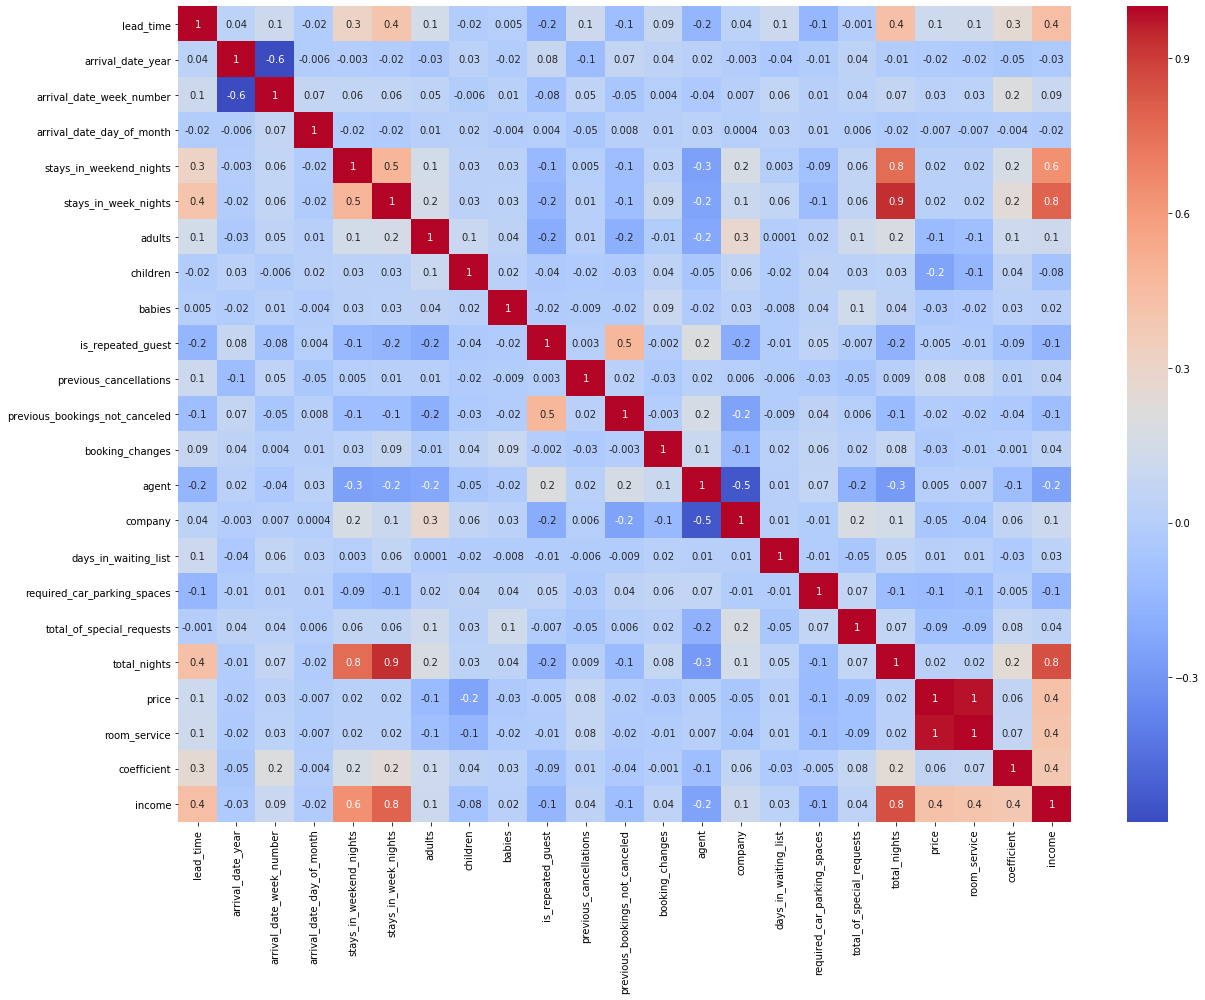

In [46]:
plt.subplots(figsize=(20,15))
sns.heatmap(features_train.corr(), annot = True, fmt='.1g', cmap= 'coolwarm')

Видна сильная взаимосвязь между признаками stays_in_week_nights, stays_in_weekend_nights и total_nights. Чтобы не перегружать модель, удаляю первые два.

In [47]:
features_train = features_train.drop(['stays_in_week_nights', 'stays_in_weekend_nights'], axis=1)
features_test = features_test.drop(['stays_in_week_nights', 'stays_in_weekend_nights'], axis=1)

In [48]:
features_train

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price,room_service,coefficient,income
0,7.0,2015,July,27,1,1,0,0,BB,GBR,Direct,0,0,0,A,C,0,999,999,0,Transient,0,0,1,600,250,1.4,590.0
1,13.0,2015,July,27,1,1,0,0,BB,GBR,Corporate,0,0,0,A,A,0,304,999,0,Transient,0,0,1,1000,400,1.4,1000.0
2,14.0,2015,July,27,1,2,0,0,BB,GBR,TA/TO,0,0,0,A,A,0,240,999,0,Transient,0,1,2,1000,400,1.4,2400.0
3,0.0,2015,July,27,1,2,0,0,BB,GBR,TA/TO,0,0,0,A,A,0,240,999,0,Transient,0,1,2,1000,400,1.4,2400.0
4,0.0,2015,July,27,1,2,0,0,BB,PRT,Direct,0,0,0,C,C,0,999,999,0,Transient,0,0,2,600,250,1.4,1430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32284,21.0,2017,August,35,31,2,0,0,BB,GBR,TA/TO,0,0,0,E,E,0,40,999,0,Contract,0,2,7,500,150,1.4,4300.0
32285,279.0,2017,August,35,31,2,0,0,BB,GBR,TA/TO,0,0,0,A,A,0,40,999,0,Contract,0,1,7,1000,400,1.4,8200.0
32286,191.0,2017,August,35,31,2,0,0,HB,GBR,TA/TO,0,0,0,D,D,0,40,999,0,Contract,0,0,7,550,150,1.4,4790.0
32287,227.0,2017,August,35,31,2,1,0,BB,CN,TA/TO,0,0,0,A,A,0,241,999,0,Transient,0,1,7,1000,400,1.4,8200.0


Проведем масштабирование признаков:

In [49]:
pd.options.mode.chained_assignment = None

columns = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 
           'adults', 'children', 'babies', 'company', 'days_in_waiting_list', 'total_of_special_requests', 
           'total_nights', 'price', 'room_service', 'coefficient', 'income']

scaler = StandardScaler()
scaler.fit(features_train[columns])

features_train[columns] = scaler.transform(features_train[columns])
features_test[columns] = scaler.transform(features_test[columns])
features_train.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price,room_service,coefficient,income
0,-0.818883,-1.521398,July,0.037847,-1.674127,-1.728052,-0.241796,-0.112204,BB,GBR,Direct,0,0,0,A,C,0,999,0.301458,-0.07451,Transient,0,-0.75047,-1.167240,-0.536774,-0.149019,1.44192,-0.991466
1,-0.752899,-1.521398,July,0.037847,-1.674127,-1.728052,-0.241796,-0.112204,BB,GBR,Corporate,0,0,0,A,A,0,304,0.301458,-0.07451,Transient,0,-0.75047,-1.167240,1.070617,1.079177,1.44192,-0.800489
2,-0.741902,-1.521398,July,0.037847,-1.674127,0.434374,-0.241796,-0.112204,BB,GBR,TA/TO,0,0,0,A,A,0,240,0.301458,-0.07451,Transient,0,0.51431,-0.725777,1.070617,1.079177,1.44192,-0.148371
3,-0.895864,-1.521398,July,0.037847,-1.674127,0.434374,-0.241796,-0.112204,BB,GBR,TA/TO,0,0,0,A,A,0,240,0.301458,-0.07451,Transient,0,0.51431,-0.725777,1.070617,1.079177,1.44192,-0.148371
4,-0.895864,-1.521398,July,0.037847,-1.674127,0.434374,-0.241796,-0.112204,BB,PRT,Direct,0,0,0,C,C,0,999,0.301458,-0.07451,Transient,0,-0.75047,-0.725777,-0.536774,-0.149019,1.44192,-0.600195


Преобразуем категориальные признаки в численные:

In [50]:
onehotencoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

features_train_arr = onehotencoder.fit_transform(features_train[features_train.select_dtypes(include = ['object']).columns])
features_labels_train = onehotencoder.get_feature_names(features_train.select_dtypes(include = ['object']).columns)
features_encoded_train = pd.DataFrame(features_train_arr, columns = features_labels_train)

In [51]:
numerics = ['int64', 'float64', 'int32', 'float32']

features_train = features_train.select_dtypes(include=numerics)
features_train = features_train.merge(features_encoded_train, how='left', left_index=True, right_index=True)

In [52]:
features_test_arr = onehotencoder.transform(features_test[features_test.select_dtypes(include = ['object']).columns])
features_labels_test = onehotencoder.get_feature_names(features_test.select_dtypes(include = ['object']).columns)
features_encoded_test = pd.DataFrame(features_test_arr, columns = features_labels_test)

features_test = features_test.select_dtypes(include=numerics)
features_test = features_test.merge(features_encoded_test, how='left', left_index=True, right_index=True)

In [53]:
features_test.isna()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,price,room_service,coefficient,income,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_ARE,country_ARG,country_ARM,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BRA,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_FIN,country_FJI,country_FRA,country_GBR,country_GGY,country_GIB,country_GRC,country_HKG,country_HRV,country_HUN,country_IDN,country_IND,country_IRL,country_IRN,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KOR,country_KWT,country_LBN,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MDG,country_MDV,country_MEX,country_MKD,country_MLT,country_MOZ,country_MUS,country_MWI,country_MYS,country_NGA,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_ROU,country_RUS,country_SAU,country_SGP,country_SMR,country_SRB,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TUN,country_TUR,country_TWN,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

Переходим непосредственно к обучению моделей. Начинаем с дерева принятия решений:

In [54]:
gs_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 8),
    'splitter': ['best', 'random'],
    'min_samples_split': range(2, 20, 2),
    'min_samples_leaf': range(1, 20, 2)
    
}

gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=0), gs_params, cv = 5, scoring = 'roc_auc')
rocauc_dt = gs_dt.fit(features_train, target_train)

print('ROC-AUC наилучшей модели: {:.2f}'.format(rocauc_dt.best_score_))
rocauc_dt.best_params_

ROC-AUC наилучшей модели: 0.74


{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 17,
 'min_samples_split': 2,
 'splitter': 'best'}

Переходим к рандомному лесу:

In [55]:
gs_params_0 = {
    'max_depth': range(1, 8),
    'n_estimators': range(100, 300, 20)
    
}

gs_rf = GridSearchCV(RandomForestClassifier(random_state=0), gs_params_0, cv = 5, scoring = 'roc_auc')
rocauc_rf = gs_rf.fit(features_train, target_train)

print('ROC-AUC наилучшей модели: {:.2f}'.format(rocauc_rf.best_score_))
rocauc_rf.best_params_

ROC-AUC наилучшей модели: 0.75


{'max_depth': 3, 'n_estimators': 280}

Логистическая регрессия:

In [56]:
gs_params_1 = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    
}

gs_lr = GridSearchCV(LogisticRegression(random_state=0), gs_params_1, cv = 5, scoring = 'roc_auc')
rocauc_lr = gs_lr.fit(features_train, target_train)

print('ROC-AUC наилучшей модели: {:.2f}'.format(rocauc_lr.best_score_))  
rocauc_lr.best_params_

ROC-AUC наилучшей модели: 0.76


{'solver': 'liblinear'}

Лучшее значение AUC-ROC показала логистическая регрессия - на тестовой выборке эту модель.

In [57]:
# Проверка модели на тестовой выборке

model = LogisticRegression(random_state=0, solver='liblinear')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_logreg = roc_auc_score(target_test, probabilities_one_test)
print('ROC-AUC =', roc_auc_logreg)

ROC-AUC = 0.8095415514989973


На всякий случай проверим также рандомный лес - на обучающей выборке он показал похожий результат.

In [58]:
model_0 = RandomForestClassifier(random_state=0, max_depth=3, n_estimators=280)
model_0.fit(features_train, target_train)
probabilities_test_0 = model_0.predict_proba(features_test)
probabilities_one_test_0 = probabilities_test_0[:, 1]
roc_auc_forest = roc_auc_score(target_test, probabilities_one_test_0)
print('ROC-AUC =', roc_auc_forest)

ROC-AUC = 0.8150410212709145


Результат оказался немного лучше, дальше будем использовать эту модель.

In [59]:
# Проверка модели на адекватность

dummy = DummyClassifier(strategy = 'constant', constant = 0).fit(features_train, target_train)
dummy_probabilities = dummy.predict_proba(features_test)
probabilities_one_dummy = dummy_probabilities[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_dummy)
print('ROC-AUC =', roc_auc)

ROC-AUC = 0.5


In [60]:
predictions = probabilities_one_test_0

In [61]:
# Функция для подсчета выручки после внедрения модели

def count_income(target, predictions):
    
    total_income = 0
    
    income = test['income'] 
    deposit = test['price'] * 0.8 
    room_service = test['room_service']
    
    for i in range(len(predictions)): 
        if target_test[i]==predictions[i]==1:
            total_income += deposit[i] - room_service[i]
        if target_test[i]==0 and target_test[i]!=predictions[i]:
            total_income += income[i]
        if target_test[i]==predictions[i]==0:
            total_income += income[i] 
        if target_test[i]==1 and target_test[i]!=predictions[i]:
            total_income += 0 - room_service[i] 
            
    return(total_income)

In [62]:
round(count_income(target_test, predictions)) - round(total_income_train)

38368990

Применение ml-модели и введение депозитной системы увеличит выручку отеля на 38 млн.

### Шаг 5. Опишите портрет «ненадёжного» клиента

Проанализируем значимость различных факторов при моделировании:

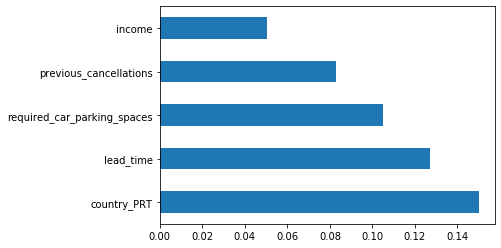

In [63]:
importances = pd.Series(model_0.feature_importances_, index=features_train.columns)
importances.nlargest().plot(kind='barh')

Итак, наиболее важные факторы для модели: количество дней между датой бронирования и датой прибытия, запрашивается ли парковочное место, отменял ли клиент брони ранее, а также на сумму выручки отеля с клиента. Но важнее всего для модели почему-то гражданство Португалии.

In [64]:
features_train[features_train['country_PRT'] == 1]

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,price,room_service,coefficient,income,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_ARE,country_ARG,country_ARM,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BRA,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_FIN,country_FJI,country_FRA,country_GBR,country_GGY,country_GIB,country_GRC,country_HKG,country_HRV,country_HUN,country_IDN,country_IND,country_IRL,country_IRN,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KOR,country_KWT,country_LBN,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MDG,country_MDV,country_MEX,country_MKD,country_MLT,country_MOZ,country_MUS,country_MWI,country_MYS,country_NGA,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_ROU,country_RUS,country_SAU,country_SGP,country_SMR,country_SRB,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TUN,country_TUR,country_TWN,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
4,-0.895864,-1.521398,0.037847,-1.674127,0.434374,-0.241796,-0.112204,0,0,0,0,999,0.301458,-0.07451,0,-0.75047,-0.725777,-0.536774,-0.149019,1.44192,-0.600195,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,-0.796888,-1.521398,0.037847,-1.674127,0.434374,-0.241796,-0.112204,0,0,0,0,303,0.301458,-0.07451,0,0.51431,-0.725777,-0.536774,-0.149019,1.44192,-0.600195,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Половина всех постояльцев - граждане Португалии. Вероятно, отель расположен в Португалии.

На основании этих данных можно вывести портрет ненадежного клиента: человек без машины, ранее отменявший брони, заезжающий на короткий срок, либо в номер низкой категории, не гражданин Португалии.

### Шаг 6. Напишите общий вывод

Наибольшую выгоду для бизнеса принесет модель, основанная на алгоритме рандомного леса. Применение данной модели и введение депозитной системы увеличит выручку отеля на 38 млн. 